In [1]:
from nn import Neuron, Layer, MLP
from value import Value

## Exploring the ```Value``` module

The purpose of the ```Value``` object is to build a framework for defining differentiable multivariable equations. These derivatives are necessary for function optimization.

### Using derivates to optimize a simple linear equation
Example:  We know how to differentiate multiplication with respect to either multiple
$$ f(a,b) = a * b $$ 
$$ {df \over da} = b; {df \over db} = a $$
$$ \nabla f = \begin{cases}
    b \\
    a 
\end{cases} $$

By knowing the derivative of this function we know how it will respond to a tiny change in the input. Given the following objective and initial value:
    $$f(b) = 2b = -8; \quad where ~ b_i = -3 $$ 
    $$ f(b_i) = 2 * -3 = -6 $$
we can use the derivate to determine in which direction our input ```b``` should be changed to get closer to our target value of 8. 
    $$ {df \over db} = 2 $$
this means for a small change to our input ```b + h``` we expect ```f(b)``` to respond in the same direction with twice the magnitude. 
    $$ h = .1; \quad b_i - h = -3 - .1 = -3.1 $$
    $$ f(-3.1) = -6.2 $$
by repeating this process until ```f(b)``` returns ```-8```, we can solve our objective!

Obviously in this example you could much more easily just solve the equation to find the answer:
    $$ b = {8 \over 2} = 4 $$

But by defining a process for differentiation for any local unary or binary operation, we can build up much more complex equations that we can still differentiate using the chain rule, and are still optimizable using the exact same method. 

Convince youself of the below example
- the ```backward()``` method is used to calculate the derivates               
- the ```data``` attribute represents a variable's value
- and ```grad``` represents the derivative of the output with respect to that variable (the result of the ```backward()``` call). 

Note: the derivate of the output with respect to itself will always be 1    e.i. $$ {df \over df} = 1 $$

In [2]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
f = a * b; f.label = "f(a,b)"
f.backward()

print(f"{a}")
print(f"{b}")
print(f"{f}")

a: Value(data=2.0, grad=-3.0)
b: Value(data=-3.0, grad=2.0)
f(a,b): Value(data=-6.0, grad=1.0)


Lets explore these more complex equations:
We already defined how to differentiate multiplication operations, but we can also easily define how to differentiate addition with respect to either addend:
$$ f(a,b) = a + b $$ 
$$ {df \over da} = 1; {df \over db} = 1 $$
$$ \nabla f = \begin{cases}
    1 \\
    1 
\end{cases} $$

lets combine this with the multiplication we already defined the derivate for, to make a more complex equation:

$$ f(a,b,c) = a * (b + c) $$

as the equation gains more variables its not as easily differentiable so lets seperate it into its individual components with an additional equation:
$$ \begin{cases}
    f(a,g) = a * g \\
    g(b,c) = b + c
\end{cases}$$

now we know how to find the derivatives of ```f(a,g)``` and ```g(b,c)``` since they are simply multiplication and addition:
$$ f(a,g) = a * g $$ 
$$ {df \over da} = g; {df \over dg} = a $$
$$ g(b,c) = b + c $$
$$ {dg \over db} = 1; {dg \over dc} = 1 $$

We already know the derivate with respect to ```a``` and ```g```, but this enables us to also find derivates with respect to ```b``` and ```c``` using the chain rule:

$$ {df \over db} = {df \over dg}*{dg \over db} $$
$$ {df \over db} = {a}*{1} = a $$  
$$ {df \over dc} = {df \over dg}*{dg \over dc} $$
$$ {df \over dc} = {a}*{1} = a $$ 

Using this process we can recursively find the derivate with respect to any variable in a complex equation, so long as we know how to differentiate every operator e.i. (```+```,```-```,```*```,```/```,```**```). The ```backward()``` method on ```Value``` objects is used to do this process recurssively through an entire equation. This process of using chain rule to recurssively propagate derivates through an equation is called backpropagation.

The same example we just did by hand above is shown below using the ```Value``` class

In [3]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(1.0, label="c")

g = b + c; g.label = "g(b,c)"
f = a * g; f.label = "f(a,g)"

f.backward()

print(f"{a}")
print(f"{b}")
print(f"{c}")
print(f"{g}")
print(f"{f}")

a: Value(data=2.0, grad=-2.0)
b: Value(data=-3.0, grad=2.0)
c: Value(data=1.0, grad=2.0)
g(b,c): Value(data=-2.0, grad=2.0)
f(a,g): Value(data=-4.0, grad=1.0)


### Visualization

To make it easier to visualize we can use a graph to represent this equation, where each variable is a node. Its not necessary to understand the code below, but to use it call ```draw_graph()``` on the root node (the final output)

In [4]:
from graphviz import Digraph

def trace(root):
    # builds set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_graph(root):
    # builds a digraph based on the does and edges produced by trace, adds 'ghost' nodes for operations
    graph = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for all values in the graph create a rectangular record node for it
        graph.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is the result of an operation, add a node for it
            graph.node(name= uid + n._op, label = n._op)
            # and connect this node to it
            graph.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        graph.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return graph

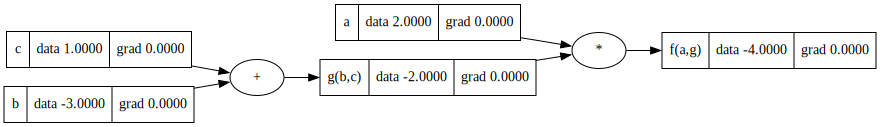

In [5]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(1.0, label="c")

g = b + c; g.label = "g(b,c)"
f = a * g; f.label = "f(a,g)"

draw_graph(f)

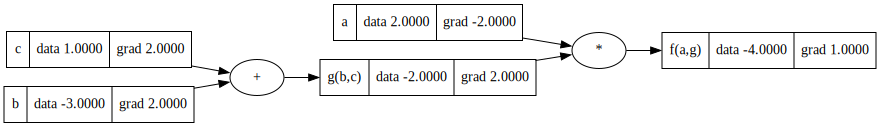

In [6]:
f.backward()
draw_graph(f)

### Implementing a single neuron manually:
<img src="neuron_model.jpeg"/>

Here our activation function with be tanh() and we will only use two inputs for simplicity

$$ output = tanh( (x1 * w1) + (x2 * w2) + b )\\
\begin{align*} 
    x1, x2 : & \quad Inputs \\
    w1, w2 : & \quad Weights \\
    b : & \quad Bias 
\end{align*}$$

```tanh()```: Activation function $$tanh(x) = {e^{2x} - 1 \over e^{2x} + 1}$$



out: Value(data=0.7071067811865476, grad=1.0)
w1: Value(data=-3.0, grad=0.9999999999999998)
w2: Value(data=1.0, grad=0.0)
b: Value(data=6.881373587019543, grad=0.4999999999999999)


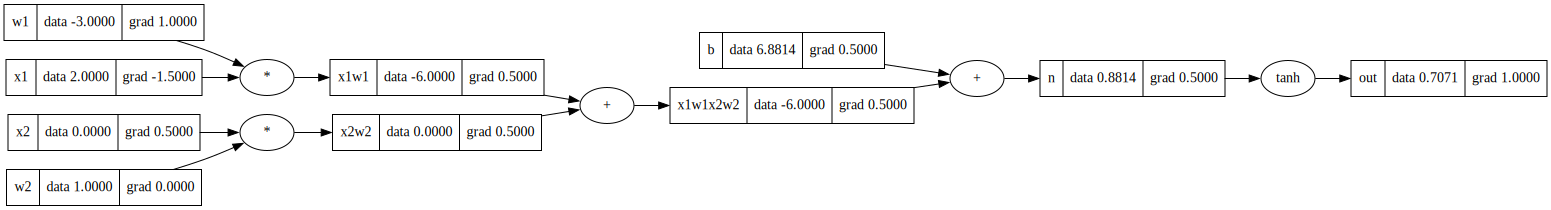

In [7]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# initial values for w_i
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# inital value for b
b = Value(6.8813735870195432, label='b')

# building the output value from only single binary or unary operations
x1w1 = x1*w1; x1w1.label='x1w1'  # x1 * w1
x2w2 = x2*w2; x2w2.label='x2w2'  # x2 * w2

x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2' #  x1*w1 + x2*w2

n = x1w1x2w2 + b; n.label='n'

# applying the activation function
o = n.tanh(); o.label='out'

## alternate form of tanh():
# e = (2 * n).exp(); e.label='e'
# o = (e - 1)/(e + 1); o.label='out'

# backpropagation
o.backward()

# output value
print(f"{o}")

# these are the values we can change, we cant change the inputs
print(f"{w1}")
print(f"{w2}")
print(f"{b}")

draw_graph(o)


### Single Neuron in Pytorch
The exact same implementation as above, but this time using Pytorch. You should be able to see the similarities between the pytorch library and what we've done.

Note: the cast to ```.double()``` is used to match the dtype from our own implementation, which is double precision by default in python

In [8]:
import torch

x1 = torch.Tensor([2.0]).double();                  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                 w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();    b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Building a Multi-Layer Perceptron from scratch

#### Neuron
First we defined a Neuron class based on the definition we discussed above:
```python
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()
```
- Each ```Neuron``` has a weight for each input and a single bias.
- When you call a ```Neuron``` as a function and provide an input of the right size, it will be evaluated:

Neuron(2)
out: Value(data=-0.9975328983408934, grad=0.0)


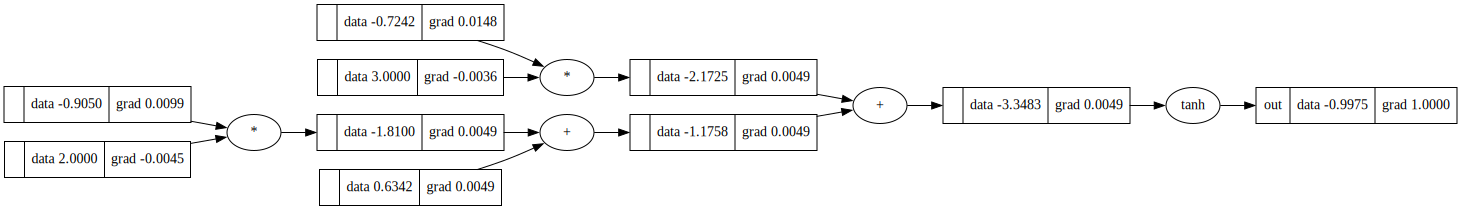

In [9]:
x = [2.0, 3.0]
n = Neuron(2)
out = n(x); out.label = "out"

print(n)
print(f"{out}")
out.backward()
draw_graph(out)

#### Layer
So far this calculation and derivation is still reasonable to do by hand, based on the graph above.

Next we define a ```Layer``` made of ```nout``` neurons each with ```nin``` inputs.

```python
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
```

- the ```neurons``` attribute is a list of the neurons in the layer
- Calling the ```Layer``` as a function and providing an input of the same length, will evaluate all of it's ```Neurons```.

Layer of [Neuron(2), Neuron(2)]


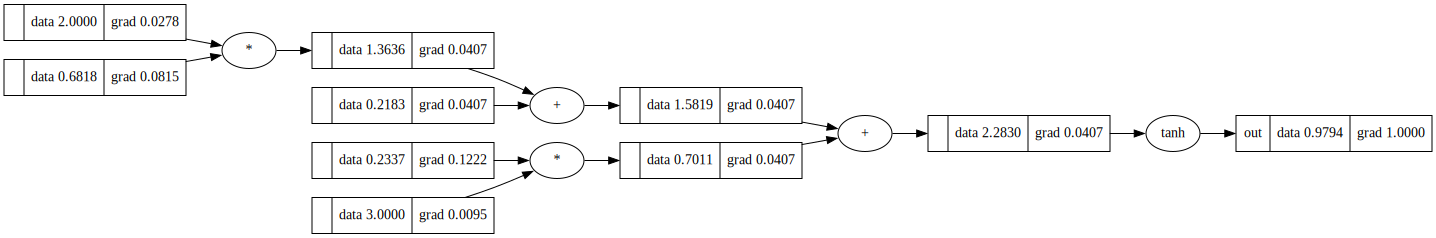

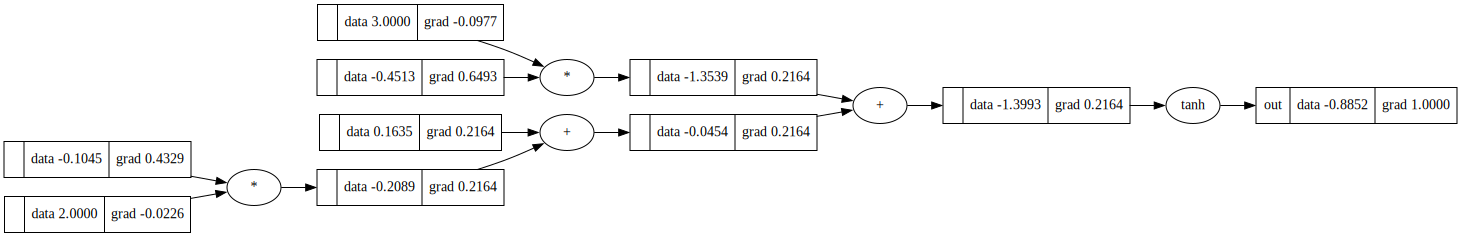

[out: Value(data=0.9794141684500199, grad=1.0), out: Value(data=-0.885196855298467, grad=1.0)]


In [10]:
x = [2.0, 3.0]
ns = Layer(2, 2)
out = [n(x) for n in ns]; # out.label = "out"

print(ns)
for o in out:
    o.label = "out"
    o.backward()
    display(draw_graph(o))
print(f"{out}")

#### MLP (Multi-Layer Perceptron)

Now with 4 Neurons, its starting to get more unreasonable to do by hand, as you can see in the graph above.

Next we define a ```MLP``` made of an input layer of size```nin``` neurons, and all following layers according to a list of ints ```nouts``` containing the sizes of each layer.

```python
class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
```

- the ```layers``` attribute is a list of the layers in the MLP
- Calling the ```MLP``` as a function and providing an input of the correct size, will evaluate all of it's ```Layers``` and therefore ```Neurons```.

MLP of [Layer of [Neuron(3), Neuron(3), Neuron(3), Neuron(3)], Layer of [Neuron(4), Neuron(4), Neuron(4), Neuron(4)], Layer of [Neuron(4)]]
out: Value(data=-0.9534713363553057, grad=0.0)


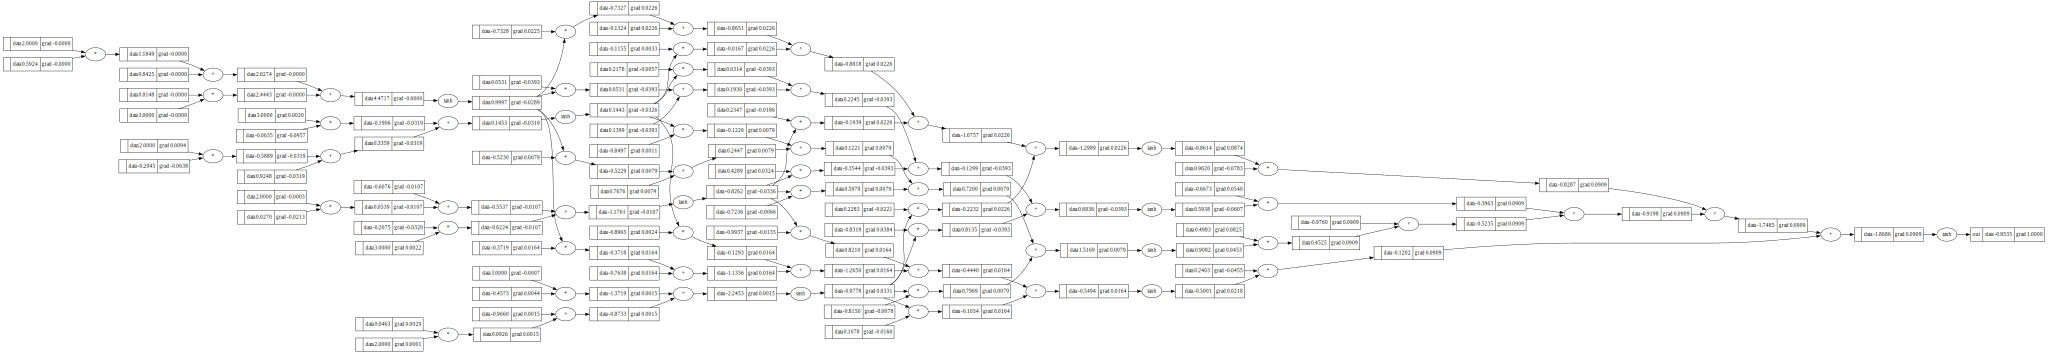

In [11]:
nin = 3 # size of input layer 
        # - how many input values are there?
nouts = [4,4,1] # size of all following layers:
                # - how many hidden layers? 
                # - what size of hidden layers? 
                # - what size of output layer?

n = MLP(nin,nouts)
out = n(x); out.label = "out"

print(n)
print(f"{out}")
out.backward()
draw_graph(out)

### Optimizing the MLP 
This is done using gradient descent with the sum of squared errors as the loss function

In [12]:
# --- inputs ---
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# --- target outputs ---
ys = [1.0, -1.0, -1.0, 1.0]

# --- optimization params:---
error = .0001      # target error
max_iter = 10000    # max iterations
h = 0.1            # step size
# --------------

# resetting the loss to non-zero
loss = Value(1.0)

nn = 0 # iter counter
while loss >= error and max_iter >= nn:  
    # nudge parameters until within the allowed error or max_iter is reached
    ypred = [n(x) for x in xs] # calculated outputs
    loss = sum([(yout-ytrue)**2 for yout, ytrue in zip(ys, ypred)])/len(ys) # calculated error

    for p in n.parameters():
        # reset gradients to 0 between iterations
        p.grad = 0.0
    
    loss.backward() # backpropagate gradients

    for p in n.parameters():
        # nudge parameters in opposite direction of gradient
        p.data += -h * p.grad
    
    nn += 1

print(f'loss:{loss.data} achieved in {nn} iterations')
print(f'predicted values:{[y.data for y in ypred]}')

loss:9.998222649741928e-05 achieved in 2710 iterations
predicted values:[0.988921952992253, -0.9933993954804899, -0.9886885578216745, 0.9897194807374701]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.datasets import make_moons, make_blobs

np.random.seed(1337)
random.seed(1337)

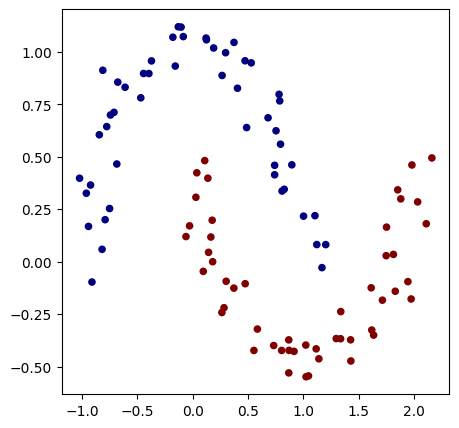

In [14]:
# make up a dataset
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [15]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2)], Layer of [Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16), Neuron(16)], Layer of [Neuron(16)]]
number of parameters 337


### Defining a loss function

Choosing a loss function is one of, if not the most important step in any optimization problem, it's what defines the objective of the optimization. In our simple optimization from earlier, our objective was just to minimize error between true and predicted values using sum of squared errors. However, in our current example, we need our loss function to find a boundary between the two categories of data. 

The popular method for classification is Support Vector Machines (SVM), you can read more about it [here](https://en.wikipedia.org/wiki/Support_vector_machine). Importantly, SVM is a supervised learning approach, meaning it requires that we have labelled training data. When data are unlabelled, supervised learning is not possible, and an unsupervised learning approach is required.

##### A linear SVM
We are given a training dataset of n n points of the form

( x<sub>1</sub> , y<sub>1</sub> ) , ... , ( x<sub>n</sub> , y<sub>n</sub> )

Where the values of _y<sub>i</sub>_ are either 1 or −1, indicating which class the point _x<sub>i</sub>_ belongs to and each _x<sub>i</sub>_ is a _p_-dimensional vector. 

We want to find the "maximum-margin hyperplane" that divides the group of points _x<sub>i</sub>_ where _y<sub>i</sub>_ = 1 from the group of points for which _y<sub>i</sub>_ = − 1. This is defined such that the distance between the hyperplane and the nearest point _x<sub>i</sub>_ from either group is maximized. It quite literally finds the plane that seperates the data with the largest margin between the two sets.

A hyperplane can be expressed as the set of points __x__ satisfying

__w__<sup>T</sup>__x__ − b = 0

where __w__ is the normal vector to the hyperplane. This hyperplane is shown as the red line in the image below

If the training data is linearly separable, we can select two parallel hyperplanes that separate the two classes of data, so that the distance between them is as large as possible. The region bounded by these two hyperplanes is called the "margin", and the maximum-margin hyperplane is the hyperplane that lies halfway between them. With a normalized or standardized dataset, these hyperplanes can be described by the equations

__w__<sup>T</sup>__x__ − b = -1

__w__<sup>T</sup>__x__ − b = 1

Geometrically, the distance between these two hyperplanes is 2‖__w__‖, so to maximize the distance between the planes we want to minimize ‖__w__‖. The distance is computed using the distance from a point to a plane equation.

##### L2 Regularization
Regularization is an important technique for avoiding overfitting, as it drives the solution toward less-complex solutions. More details about it can be found [here](https://towardsdatascience.com/over-fitting-and-regularization-64d16100f45c)

We will use L2 regularization, the difference between L1 and L2 regularization is explained in the blog post [here](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)

<img src="SVM_margin.jpg" width=400px height=400px/>

In [16]:
# loss function
def loss():
    
    # converts each item in list of x,y positions from array of floats to array of `Value`` instances
    inputs = [list(map(Value, xrow)) for xrow in X]

    # pass these inputs to the MLP stored in `model` and store the model's outputs in `scores`
    y_pred = list(map(model, inputs))
    
    # svm "max-margin" loss implemented using relu
    losses = [(1 + -yi*yp).relu() for yi, yp in zip(y, y_pred)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))

    # add L2 regularization into the loss
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (yp.data > 0) for yi, yp in zip(y, y_pred)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

: Value(data=0.7840043023159258, grad=0.0) 0.68


In [17]:
# optimization
for k in range(115):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.7840043023159258, accuracy 68.0%
step 1 loss 0.5346887893624206, accuracy 73.0%
step 2 loss 0.40486112398826374, accuracy 83.0%
step 3 loss 0.3380828095624803, accuracy 86.0%
step 4 loss 0.2942618979033041, accuracy 88.0%
step 5 loss 0.2713707188453524, accuracy 90.0%
step 6 loss 0.25577580370370173, accuracy 90.0%
step 7 loss 0.24353269446140008, accuracy 91.0%
step 8 loss 0.2331166633588174, accuracy 91.0%
step 9 loss 0.22371429713875027, accuracy 91.0%
step 10 loss 0.2147884062041821, accuracy 91.0%
step 11 loss 0.20603142190103874, accuracy 91.0%
step 12 loss 0.19722264277587243, accuracy 92.0%
step 13 loss 0.18824544635214918, accuracy 93.0%
step 14 loss 0.17902966856680746, accuracy 94.0%
step 15 loss 0.16967500545392217, accuracy 94.0%
step 16 loss 0.1603343984865978, accuracy 94.0%
step 17 loss 0.15200986278726364, accuracy 96.0%
step 18 loss 0.14550876426551504, accuracy 96.0%
step 19 loss 0.15276142639895698, accuracy 95.0%
step 20 loss 0.14406510423987684, accu

(-0.848639298268643, 1.4013607017313587)

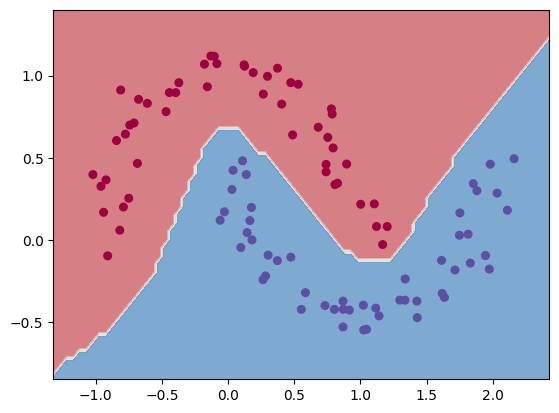

In [18]:
# visualize decision boundary

res = 0.05 # boundary resolution
buf = 0.3 # buffer on the edges of the plot

# --- Sampling data points: ---

# get the minimum and maximum values of all the x coordinates with a small buffer
x_min, x_max = X[:, 0].min() - buf, X[:, 0].max() + buf
# get the minimum and maximum values of all the y coordinates in X with a small buffer in both directions 
y_min, y_max = X[:, 1].min() - buf, X[:, 1].max() + buf

# create a 2D meshgrid between the min and max values, 
xx, yy = np.meshgrid(np.arange(x_min, x_max, res), 
                     np.arange(y_min, y_max, res))

# flattens the 2D meshgrid into a 2xN array of coordinate pairs
Xmesh = np.c_[xx.ravel(), yy.ravel()]

# --- Evaluating sampled data points: ---
# converts the 2xN array of floats into a list of length N, where each elements is an array containing two Values
inputs = [list(map(Value, xrow)) for xrow in Xmesh]

# passes the inputs to the model and stores the output in `scores`
y_pred = list(map(model, inputs))

# --- Assigning categories: ---
# Create an array of bools assigning each sample data point to a class depending on its sign
# >0 :   True
# <=0 :  False
Z = np.array([yp.data > 0 for yp in y_pred])

# reshape the bool array back to the shape of the orginal 2D mesh
Z = Z.reshape(xx.shape)


# --- Plotting: ---
fig = plt.figure()
# plot the contour based on the category assignments `Z`
plt.contourf(xx, yy, Z, 3, cmap=plt.colormaps['RdBu'], alpha=0.6)
# plot the input data points
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Spectral)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())